<a href="https://colab.research.google.com/github/abia200304/IIIT-Hyderabad-Research_works/blob/main/SAE_LSTM_pems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!unzip -o /content/my_pems_data.zip

Archive:  /content/my_pems_data.zip
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-2024_0600.csv  
  inflating: m

In [1]:
from glob import glob
import pandas as pd
import numpy as np

file_paths = glob('/content/my_pems_data/*.csv')
all_data = []

for file in file_paths:
    try:
        df = pd.read_csv(file, delimiter='\t')
        df.columns = df.columns.str.strip()
        if 'Flow (Veh/5 Minutes)' in df.columns and 'Truck Flow (Veh/5 Minutes)' in df.columns:
            all_data.append(df[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])
        else:
            print(f"Skipping {file}: Required columns not found")
    except Exception as e:
        print(f"Error reading {file}: {e}")


In [2]:
combined_df = pd.concat(all_data, ignore_index=True)
print(combined_df.shape)

(22824, 2)


In [3]:
def process_traffic_data(df):

    processed_df = df.copy()

    processed_df = processed_df.rename(columns={
        'Flow (Veh/5 Minutes)': 'total_flow',
        'Truck Flow (Veh/5 Minutes)': 'truck_flow'
    })

    if 'total_flow' not in processed_df.columns or 'truck_flow' not in processed_df.columns:
        print("Error: Renaming of columns failed. Check original column names.")
        return None

    # Calculate Non-Truck Flow = Total Flow - Truck Flow
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']

    # Handle any negative values
    negative_mask = processed_df['non_truck_flow'] < 0
    if negative_mask.sum() > 0:
        print(f"⚠️ Warning: {negative_mask.sum()} rows have negative non-truck flow values")
        processed_df.loc[negative_mask, 'non_truck_flow'] = 0

    # Add time-based features
    processed_df['time_index'] = range(len(processed_df))

    return processed_df


In [4]:
processed_df = process_traffic_data(combined_df)


In [5]:
display(processed_df)
print(processed_df.shape)

,total_flow,truck_flow,non_truck_flow,time_index
0,22.0,0.0,22.0,0
1,26.0,1.0,25.0,1
2,14.0,1.0,13.0,2
3,16.0,0.0,16.0,3
4,17.0,1.0,16.0,4
...,...,...,...,...
22819,30.0,0.0,30.0,22819
22820,27.0,0.0,27.0,22820
22821,25.0,0.0,25.0,22821
22822,15.0,0.0,15.0,22822


(22824, 4)


In [6]:

processed_df.columns

Index(['total_flow', 'truck_flow', 'non_truck_flow', 'time_index'], dtype='object')

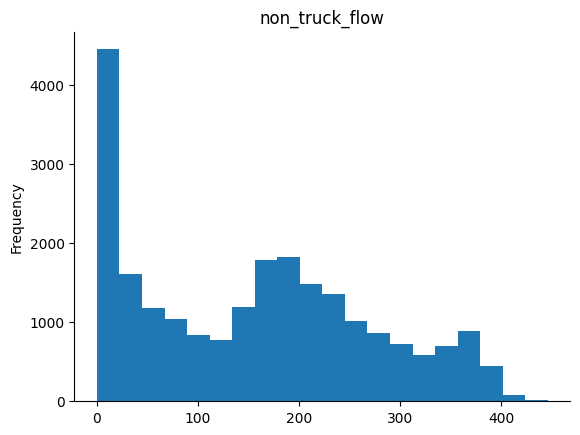

In [7]:
from matplotlib import pyplot as plt
processed_df['non_truck_flow'].plot(kind='hist', bins=20, title='non_truck_flow')
plt.gca().spines[['top', 'right',]].set_visible(False)

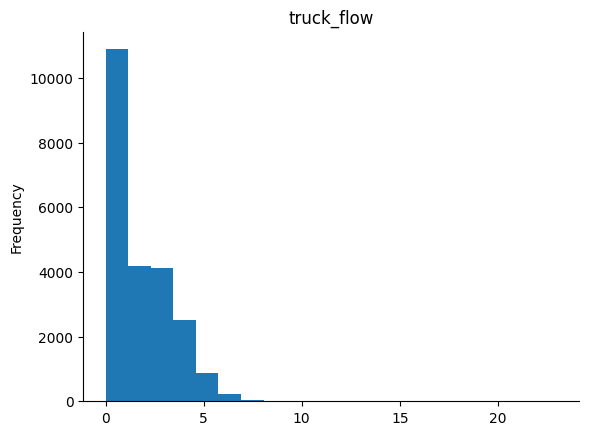

In [8]:
from matplotlib import pyplot as plt
processed_df['truck_flow'].plot(kind='hist', bins=20, title='truck_flow')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
column_1_data = processed_df['truck_flow']
column_2_data = processed_df['non_truck_flow']

In [10]:
coloumn_1_data=np.array(column_1_data)
coloumn_2_data=np.array(column_2_data)

In [11]:
column1_data=coloumn_1_data.reshape(-1,1)
column2_data =coloumn_2_data.reshape(-1,1)

In [12]:
data = np.concatenate([ column1_data,column2_data],axis =1)
print(data.shape)

(22824, 2)


In [15]:
from sklearn.preprocessing import MinMaxScaler

scalar=MinMaxScaler((0,1))
scaled_data=scalar.fit_transform(data)

In [16]:
scaled_data.shape

(22824, 2)

In [17]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)
time_step = 15
X, Y= create_dataset(scaled_data, time_step)
print(X.shape)
print(Y.shape)

(22809, 15, 2)
(22809, 2)


In [18]:
X_train=X[:int(0.8*len(X))]
y_train = Y[:int(0.8*len(Y))].reshape(-1,2)
X_test = X[int(0.8*len(X)):]
y_test = Y[int(0.8*len(Y)):].reshape(-1,2)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18247, 15, 2)
(18247, 2)
(4562, 15, 2)
(4562, 2)


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
import numpy as np
from keras import regularizers

#SAE
sparsity_level = 0.05       # e.g., target average activation
lambda_sparse = 0.001       # weight for KL divergence
encoding_dim = 32  #  latent space (bottleneck)
# encoder
input = keras.Input(shape=(15, 2))


encoded = layers.LSTM(encoding_dim, activation='relu',kernel_regularizer=regularizers.l2(0.1))(input)
encoder = keras.Model(inputs=input, outputs=encoded)

# decoder
encoded_input = keras.Input(shape=(encoding_dim,))
decoded = layers.Dense(30, activation='linear')(encoded_input) # Changed from 60 to 30
reshaped_output = layers.Reshape((15, 2))(decoded)
decoder = keras.Model(inputs=encoded_input, outputs=reshaped_output)

# Autoencoder: encoder + decoder
autoencoder_input = keras.Input(shape=(15, 2))
encoded_output = encoder(autoencoder_input)
decoded_output = decoder(encoded_output)
autoencoder = keras.Model(inputs=autoencoder_input, outputs=decoded_output)

def sparse_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(keras.losses.MeanSquaredError()(y_true, y_pred))
    hidden = encoder(y_true)
    mean_activation = tf.reduce_mean(hidden, axis=0)
    mean_activation = tf.clip_by_value(mean_activation, 1e-6, 1 - 1e-6) #clip_by_function to avoid log(0)
    kl_div = tf.reduce_sum(
        sparsity_level * tf.math.log(sparsity_level / mean_activation) +
        (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_activation))
    )
    return mse_loss + lambda_sparse * kl_div

In [21]:
history=autoencoder.compile(optimizer='adam', loss=sparse_loss)
history=autoencoder.fit(X_train, X_train, epochs=50, validation_split=0.15)

Epoch 1/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1531 - val_loss: 0.0046
Epoch 2/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 3/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 4/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 5/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 6/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 7/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 8/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 9/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 10/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 11/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 12/50
485/485 ━━━━━━━━━━━━━━━━━━

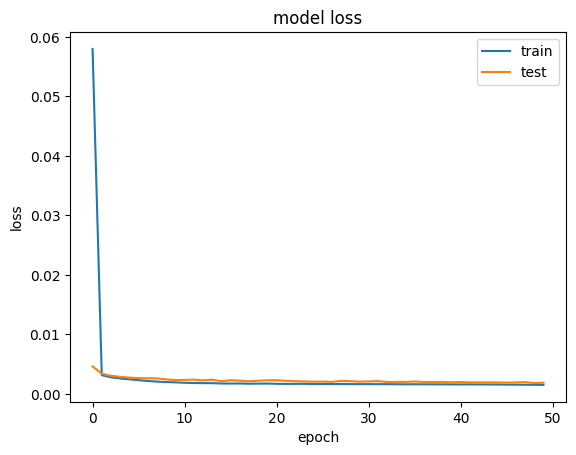

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')


In [23]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
y_pred=autoencoder.predict(X_test)
test_predict=autoencoder.predict(X_test)
print(test_predict.shape)

predictions_original_scale = scalar.inverse_transform(test_predict[:, -1, :])
y_test_original_scale = scalar.inverse_transform(y_test)
mae=mean_absolute_error(predictions_original_scale,y_test_original_scale,)
mse=np.sqrt(mean_squared_error(predictions_original_scale,y_test_original_scale,))

epsilon = 1e-10
mape=mean_absolute_percentage_error(predictions_original_scale,y_test_original_scale + epsilon,)

rmse=np.sqrt(mse)
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(4562, 15, 2)
RMSE: 4.121659085697332
MSE: 16.988073618711365
MAE: 8.327774144209357
MAPE: 0.613791095737211


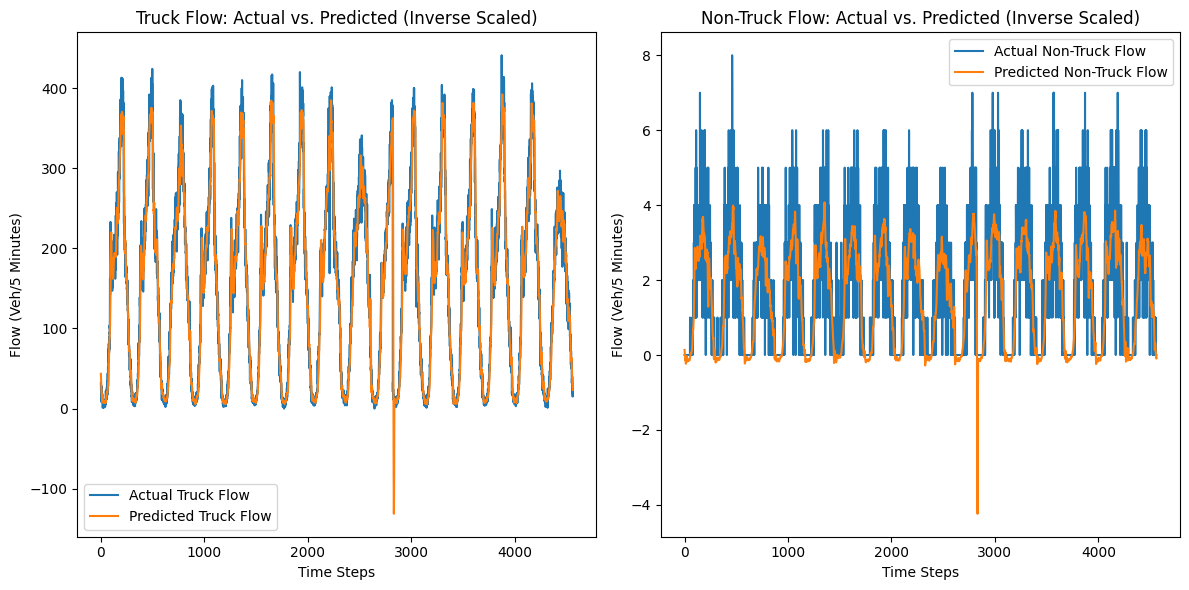

In [24]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

#  Truck Flow
plt.subplot(1, 2, 1)
plt.plot(y_test_original_scale[:, 1], label='Actual Truck Flow')
plt.plot(predictions_original_scale[:, 1], label='Predicted Truck Flow')
plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

# Non-Truck Flow
plt.subplot(1, 2, 2)
plt.plot(y_test_original_scale[:, 0] , label='Actual Non-Truck Flow')
plt.plot(predictions_original_scale[:, 0], label='Predicted Non-Truck Flow')
plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

plt.tight_layout()
plt.show()